In [0]:
try:
    import Sastrawi
except ModuleNotFoundError:
    ! pip install PySastrawi
finally:
    from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import os
import pandas as pd

if not os.path.exists('detik_news_title.csv'):
    ! wget https://ibam.imfast.io/detik_news_title.csv


df = pd.read_csv('detik_news_title.csv').drop(columns=['Unnamed: 0'])
df.head()

,date,url,title,category
0,02/26/2020,https://finance.detik.com/berita-ekonomi-bisni...,Kemnaker Awasi TKA di Meikarta,finance
1,02/26/2020,https://finance.detik.com/berita-ekonomi-bisni...,BNI Digitalkan BNI Java Jazz 2020,finance
2,02/26/2020,https://finance.detik.com/berita-ekonomi-bisni...,"Terbang ke Australia, Edhy Prabowo Mau Genjot ...",finance
3,02/26/2020,https://finance.detik.com/moneter/d-4916133/oj...,OJK Siapkan Stimulus Ekonomi Antisipasi Dampak...,finance
4,02/26/2020,https://finance.detik.com/berita-ekonomi-bisni...,Saran Buat Anies-RK yang Mangkir Rapat Banjir ...,finance


## Word Count per Title

count    91017.000000
mean         9.273674
std          1.891406
min          1.000000
25%          8.000000
50%          9.000000
75%         11.000000
max         20.000000
Name: word_count, dtype: float64

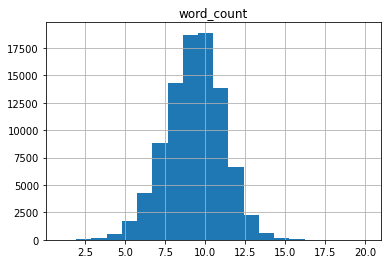

In [0]:
df['word_count'] = df['title'].apply(lambda x: len(str(x).split(' ')))
df[['title', 'word_count']].head()
df.hist(bins=20)
df.word_count.describe()

## Most Common and Uncommon Words per Category

In [0]:
def get_top_words(df, n=10, column='title'):
    top_words = pd.Series(' '.join(df[column]).split()).value_counts()[:n]
    print(f'Top words {df.category.unique()[0]} category: ', end='')
    for index, value in top_words.items():
        print(f'{index} ({value}), ', end='')
    print('\n')

for cat in df.category.unique():
    get_top_words(df[df.category == cat])

Top words finance category: di (2555), Corona (1645), Ini (1465), Rp (1387), ke (1116), RI (951), yang (805), dan (753), Bisa (703), Corona, (699), 

Top words food category: Ini (1690), di (1253), yang (1091), 5 (847), dan (814), Makanan (673), Makan (521), Foto (458), Galeri (438), hingga (415), 

Top words health category: Corona (2064), di (1275), Virus (1026), Ini (1024), yang (713), Pasien (472), Bisa (431), Corona, (385), dan (372), untuk (369), 

Top words hot category: di (3100), dan (1649), yang (1365), Ini (1197), Tak (1076), Jadi (1001), Corona (997), dengan (913), dari (799), ke (672), 

Top words inet category: di (1076), Corona (665), Ini (543), dan (518), yang (494), Virus (336), Ponsel (298), dari (267), untuk (258), Bikin (253), 

Top words news category: di (13632), Corona (5488), yang (2495), ke (2342), Tak (2235), Ini (2101), Kasus (1938), Warga (1881), Polisi (1854), dan (1782), 

Top words oto category: Mobil (1125), di (957), Ini (669), yang (483), Motor (414), 

## Text Preprocessing

In [0]:
import re
def preprocess(text):
    # remove punctuation
    text = re.sub('[^a-zA-Z]', ' ', text)
    # convert to lower case
    text = text.lower()
    # remove special char and digit
    text=re.sub("(\\d|\\W)+"," ",text)
    # remove stop words
    stopword = StopWordRemoverFactory().create_stop_word_remover() 
    text = stopword.remove(text)
    # stemming
    stemmer = StemmerFactory().create_stemmer()
    text = stemmer.stem(text)
    return text

import time

start_time = time.time()
for i in range(0, len(df)):
    if (i%500) == 0:
        mid_time = time.time()
        print(f'Processing #{i} data, {(mid_time - start_time):.2f} seconds elapsed.')

    df.at[i, 'corpus'] = preprocess(df['title'][i])

end_time = time.time()
print(f'End processing {len(df)} data for {(end_time-start_time):.2f} seconds.')
df.head(15)

Processing #0 data, 0.00 seconds elapsed.
Processing #500 data, 3.46 seconds elapsed.
Processing #1000 data, 6.91 seconds elapsed.
Processing #1500 data, 10.27 seconds elapsed.
Processing #2000 data, 13.88 seconds elapsed.
Processing #2500 data, 17.11 seconds elapsed.
Processing #3000 data, 20.61 seconds elapsed.
Processing #3500 data, 24.00 seconds elapsed.
Processing #4000 data, 27.43 seconds elapsed.
Processing #4500 data, 30.83 seconds elapsed.
Processing #5000 data, 34.20 seconds elapsed.
Processing #5500 data, 37.62 seconds elapsed.
Processing #6000 data, 40.89 seconds elapsed.
Processing #6500 data, 44.27 seconds elapsed.
Processing #7000 data, 47.64 seconds elapsed.
Processing #7500 data, 50.99 seconds elapsed.
Processing #8000 data, 54.61 seconds elapsed.
Processing #8500 data, 58.21 seconds elapsed.
Processing #9000 data, 61.71 seconds elapsed.
Processing #9500 data, 65.18 seconds elapsed.
Processing #10000 data, 68.73 seconds elapsed.
Processing #10500 data, 72.19 seconds el

,date,url,title,category,word_count,corpus
0,02/26/2020,https://finance.detik.com/berita-ekonomi-bisni...,Kemnaker Awasi TKA di Meikarta,finance,5,kemnaker awas tka meikarta
1,02/26/2020,https://finance.detik.com/berita-ekonomi-bisni...,BNI Digitalkan BNI Java Jazz 2020,finance,6,bni digital bni java jazz
2,02/26/2020,https://finance.detik.com/berita-ekonomi-bisni...,"Terbang ke Australia, Edhy Prabowo Mau Genjot ...",finance,10,terbang australia edhy prabowo genjot budi day...
3,02/26/2020,https://finance.detik.com/moneter/d-4916133/oj...,OJK Siapkan Stimulus Ekonomi Antisipasi Dampak...,finance,7,ojk siap stimulus ekonomi antisipasi dampak co...
4,02/26/2020,https://finance.detik.com/berita-ekonomi-bisni...,Saran Buat Anies-RK yang Mangkir Rapat Banjir ...,finance,9,saran anies rk mangkir rapat banjir dpr
5,02/26/2020,https://finance.detik.com/berita-ekonomi-bisni...,RI Bakal Punya Destinasi Wisata Sejarah Islam ...,finance,9,ri destinasi wisata sejarah islam ancol
6,02/26/2020,https://finance.detik.com/perencanaan-keuangan...,Cara Biar Nggak Tertipu Travel Umrah Abal-abal...,finance,10,biar nggak tipu travel umrah abal abal first t...
7,02/26/2020,https://finance.detik.com/berita-ekonomi-bisni...,"DPR Kritik Cara Anies Atasi Banjir, Pesan Kera...",finance,12,dpr kritik anies atas banjir pesan keras erick...
8,02/26/2020,https://finance.detik.com/moneter/d-4916086/ja...,Jadi Korban Gagal Bayar Asuransi? Bisa Mengadu...,finance,9,korban gagal bayar asuransi adu
9,02/26/2020,https://finance.detik.com/berita-ekonomi-bisni...,Erick Thohir: BUMN Bukan Badan Usaha Milik Nen...,finance,9,erick thohir bumn badan usaha milik nenek lu


## Extracting the Topic using TF-IDF

### Create a word count vector using CountVectorizer

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(max_df=0.8, max_features=10000, ngram_range=(1,2))
X=cv.fit_transform(df['corpus'])

#### Visualize Top Word (Single n-gram and bigram)

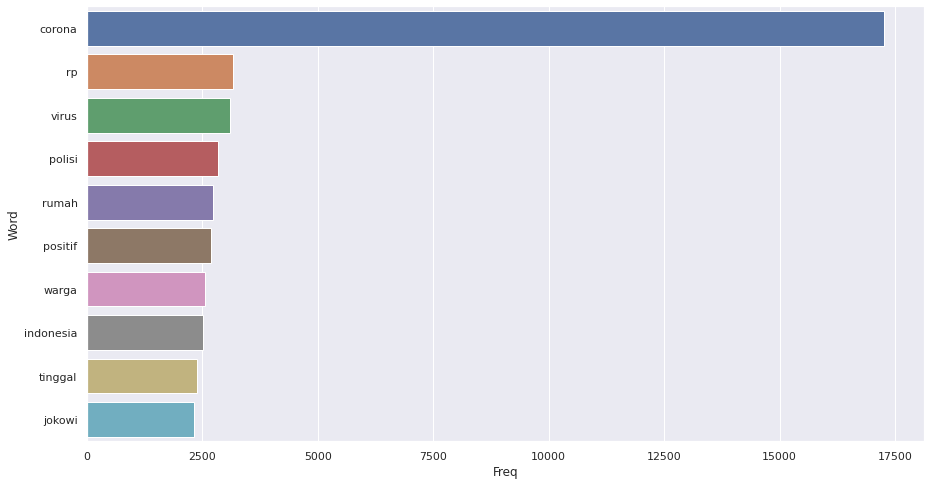

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(df['corpus'], n=10)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
# #Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)})
g = sns.barplot(x="Freq", y="Word", data=top_df)

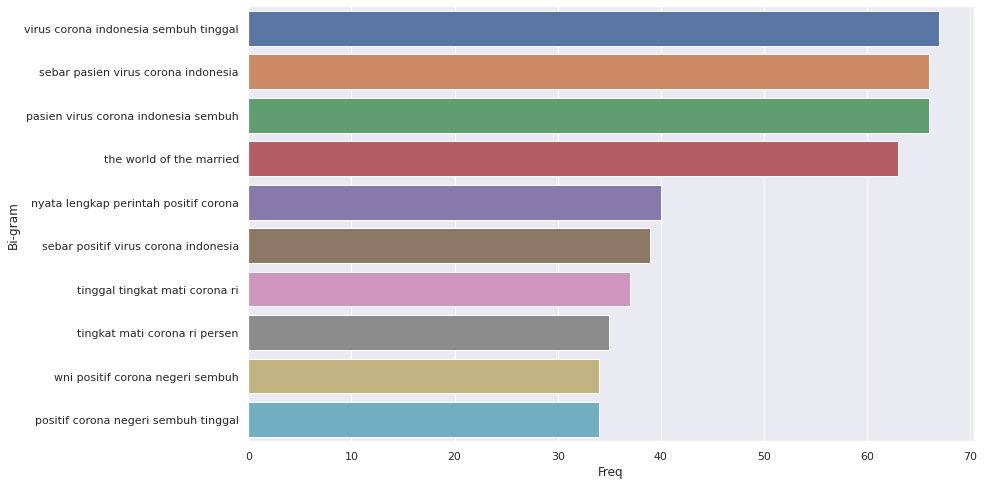

In [0]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(5,5),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(df['corpus'], n=10)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Freq", y="Bi-gram", data=top2_df)

## Create TF-IDF Vector using vector of wordcount

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

## Extracting Topic from Random Title

In [0]:
feature_names=cv.get_feature_names()
b
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,5)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Abstract:
Pengakuan Kepsek di Bandung Kerap Dihubungi 'Titip Siswa' Saat PPDB

Keywords:
ppdb 0.459
kepsek 0.44
titip 0.438
kerap 0.397
siswa 0.356


Credits:
https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34